In [1]:
from drl4dypm.agent import *
from drl4dypm.env import *
import time, copy

from matplotlib import pyplot as plt

In [2]:
# environment params
trading_days = 252
asset_names = ['AAL','CVS','FDX','F','AIG','CAT']
k = 10
cost_bps = 1e-3
path_to_data = 'data/stock_price_1D.csv'

# agent params
num_assets = len(asset_names)
state_dim = 3*(1+num_assets)
action_dim = 1+num_assets

critic_learning_rate = 1e-3
actor_learning_rate = critic_learning_rate * 0.5


# training params
max_episode = 50


# With and without last action as state

## network params

In [3]:
network_params = {
    'actor': {
        'fc': [64,32,16],
        'dropout': 0.5
    },
    'critic': {
        'fc': [64,32,16],
        'dropout': 0.5
    }
}

## setup

In [4]:
agent_wo_act = RLAgent(state_dim,
                action_dim,
                k,
                network_params,
                actor_learning_rate,
                critic_learning_rate,
                last_action_as_state=False
               )

agent_w_act = RLAgent(state_dim,
                action_dim,
                k,
                network_params,
                actor_learning_rate,
                critic_learning_rate
               )

[2021-03-07 23:07:36,933] <WARNING>:default_logger:The reduction property of criterion is not 'none', automatically corrected.
[2021-03-07 23:07:36,940] <WARNING>:default_logger:The reduction property of criterion is not 'none', automatically corrected.


In [5]:
env = TradingEnvironment(num_steps=trading_days, 
                         asset_names=asset_names, 
                         k=k, 
                         cost_bps=cost_bps,
                         agent_names=['wo_act','w_act'],
                         path_to_data=path_to_data
                        )

## training

In [6]:
env.reset()

reward_wo_act = []
elp_wo_act = []

reward_w_act = []
elp_w_act = []

reward_sm_wo_act = 0
reward_sm_w_act = 0
elp_sum = 0
start_time = time.time()

cols = ['r_wo_act','c_l_wo_act','a_v_wo_act',
        'r_w_act','c_l_w_act','a_v_w_act',
        'elp','elp_sum']
line = 'episode |' + '|'.join([f'{col:<12}' for col in cols])
print(line)


for e in range(max_episode):
    state, end = env.init_step()
    last_actions = env.simulator.last_actions
    
    while not end:
        with torch.no_grad():
            # generate action
            action_wo_act = agent_wo_act.get_action(torch.tensor(state[1], dtype=torch.float32).view(1,-1))
            
            action_w_act = agent_w_act.get_action(torch.tensor(state[1], dtype=torch.float32).view(1,-1),
                                     torch.tensor(last_actions['w_act'], dtype=torch.float32).view(1,-1))
            
            # execute action and move to next step
            actions = {'wo_act': action_wo_act.numpy().reshape(-1),
                      'w_act': action_w_act.numpy().reshape(-1)}
            rewards, next_state, end = env.take_step(actions, state[0])
            
            # store experience
            agent_wo_act.store_transition({
                'state': {'state': torch.tensor(state[1], dtype=torch.float32).view(1,-1)},
                'action': {'action': torch.tensor(actions['wo_act'], dtype=torch.float32).view(1,-1)},
                'next_state': {'state': torch.tensor(next_state[1], dtype=torch.float32).view(1,-1)},
                'reward': rewards['wo_act'],
                'terminal': end
            })
            
            agent_w_act.store_transition({
                'state': {'state': torch.tensor(state[1], dtype=torch.float32).view(1,-1),
                         'last_action': torch.tensor(last_actions['w_act'], dtype=torch.float32).view(1,-1)},
                'action': {'action': torch.tensor(actions['w_act'], dtype=torch.float32).view(1,-1)},
                'next_state': {'state': torch.tensor(next_state[1], dtype=torch.float32).view(1,-1),
                              'last_action': torch.tensor(actions['w_act'], dtype=torch.float32).view(1,-1)},
                'reward': rewards['w_act'],
                'terminal': end
            })
        
        
        state = next_state
        last_actions = actions
        
    
    # update 
    start_time_wo_act = time.time()
    for _ in range(trading_days):
        actor_value_wo_act, critic_loss_wo_act = agent_wo_act.update(return_loss=True)
    elp_wo_act.append(time.time() - start_time_wo_act)
    
    start_time_w_act = time.time()
    for _ in range(trading_days):
        actor_value_w_act, critic_loss_w_act = agent_w_act.update(return_loss=True)
    elp_w_act.append(time.time() - start_time_w_act)
    
        
    rewards = env.get_total_rewards()
    reward_sm_wo_act = reward_sm_wo_act * 0.9 + rewards['wo_act'] * 0.1
    reward_corr_wo_act = reward_sm_wo_act/(1-0.9**(e+1))
    
    
    reward_sm_w_act = reward_sm_w_act * 0.9 + rewards['w_act'] * 0.1
    reward_corr_w_act = reward_sm_w_act/(1-0.9**(e+1))

    elp = time.time()-start_time
    elp_sum += elp
    start_time = time.time()
    
    reward_wo_act.append(reward_corr_wo_act)
    reward_w_act.append(reward_corr_w_act)
    
    
    line = f'{e:<8}|' + '|'.join([f'{col:<12.4f}' for col in [reward_corr_wo_act, critic_loss_wo_act, actor_value_wo_act,
                                                               reward_corr_w_act, critic_loss_w_act, actor_value_w_act,
                                                              elp, elp_sum]])
    
    print(line)
    
    env.reset()

[2021-03-07 23:07:40,154] <WARNING>:default_logger:You have not specified the i/o device of your model <class 'drl4dypm.agent.Actor'>, automatically determined and set to: cpu
The framework is not responsible for any un-matching device issues caused by this operation.
[2021-03-07 23:07:40,160] <WARNING>:default_logger:You have not specified the i/o device of your model <class 'drl4dypm.agent.Actor'>, automatically determined and set to: cpu
The framework is not responsible for any un-matching device issues caused by this operation.


episode |r_wo_act    |c_l_wo_act  |a_v_wo_act  |r_w_act     |c_l_w_act   |a_v_w_act   |elp         |elp_sum     


[2021-03-07 23:07:40,984] <WARNING>:default_logger:You have not specified the i/o device of your model <class 'drl4dypm.agent.Actor'>, automatically determined and set to: cpu
The framework is not responsible for any un-matching device issues caused by this operation.
[2021-03-07 23:07:40,986] <WARNING>:default_logger:You have not specified the i/o device of your model <class 'drl4dypm.agent.Critic'>, automatically determined and set to: cpu
The framework is not responsible for any un-matching device issues caused by this operation.
[2021-03-07 23:07:40,987] <WARNING>:default_logger:You have not specified the i/o device of your model <class 'drl4dypm.agent.Critic'>, automatically determined and set to: cpu
The framework is not responsible for any un-matching device issues caused by this operation.
[2021-03-07 23:07:43,372] <WARNING>:default_logger:You have not specified the i/o device of your model <class 'drl4dypm.agent.Actor'>, automatically determined and set to: cpu
The framework i

0       |0.0628      |0.0004      |0.0067      |0.0314      |0.0005      |0.0222      |6.0412      |6.0412      
1       |-0.0565     |0.0003      |0.0091      |0.0098      |0.0002      |0.0251      |5.9152      |11.9564     
2       |-0.1427     |0.0002      |0.0074      |-0.0251     |0.0003      |0.0239      |5.4623      |17.4187     
3       |-0.0982     |0.0003      |0.0081      |-0.0470     |0.0003      |0.0230      |5.5284      |22.9471     
4       |-0.1627     |0.0002      |0.0072      |-0.1630     |0.0002      |0.0261      |5.5423      |28.4894     
5       |-0.1278     |0.0002      |0.0091      |-0.1397     |0.0002      |0.0235      |5.5345      |34.0239     
6       |-0.1042     |0.0002      |0.0091      |-0.1495     |0.0002      |0.0256      |5.7181      |39.7420     
7       |-0.1120     |0.0001      |0.0084      |-0.1079     |0.0003      |0.0235      |5.5036      |45.2456     
8       |-0.0948     |0.0002      |0.0086      |-0.1048     |0.0002      |0.0271      |5.5099   

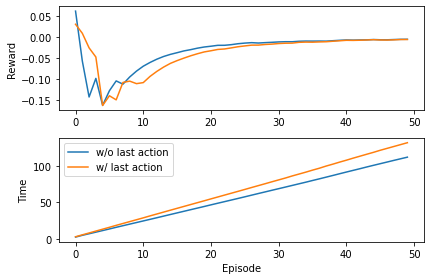

In [7]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(6,4))

ax1.plot(reward_wo_act)
ax1.plot(reward_w_act)


ax2.plot(np.array(elp_wo_act).cumsum(), label='w/o last action')
ax2.plot(np.array(elp_w_act).cumsum(), label='w/ last action')

ax1.set_ylabel('Reward')
ax2.set_ylabel('Time')
ax2.set_xlabel('Episode')
ax2.legend()

fig.tight_layout()
fig.savefig('figs/cmp_last_act.png')

## test

In [10]:
env.reset()

price_epi = []
action_epi_wo_act = []
action_epi_w_act = []
reward_epi_wo_act = []
reward_epi_w_act = []



state, end = env.init_step()
last_actions = env.simulator.last_actions
    
while not end:
    with torch.no_grad():
        # generate action
        action_wo_act = agent_wo_act.get_action(torch.tensor(state[1], dtype=torch.float32).view(1,-1))

        action_w_act = agent_w_act.get_action(torch.tensor(state[1], dtype=torch.float32).view(1,-1),
                                 torch.tensor(last_actions['w_act'], dtype=torch.float32).view(1,-1))

        # execute action and move to next step
        actions = {'wo_act': action_wo_act.numpy().reshape(-1),
                  'w_act': action_w_act.numpy().reshape(-1)}
        rewards, next_state, end = env.take_step(actions, state[0])


    state = next_state
    last_actions = actions
    
    price_epi.append(state[0])
    action_epi_wo_act.append(action_wo_act.numpy().reshape(-1))
    action_epi_w_act.append(action_w_act.numpy().reshape(-1))
    reward_epi_wo_act.append(rewards['wo_act'])
    reward_epi_w_act.append(rewards['w_act'])

    

In [17]:
reward_epi_wo_act = np.array(reward_epi_wo_act).cumsum()
reward_epi_w_act = np.array(reward_epi_w_act).cumsum()

price_epi = np.array(price_epi)
action_epi_wo_act = np.array(action_epi_wo_act)
action_epi_w_act = np.array(action_epi_w_act)


Text(0, 0.5, 'Total reward')

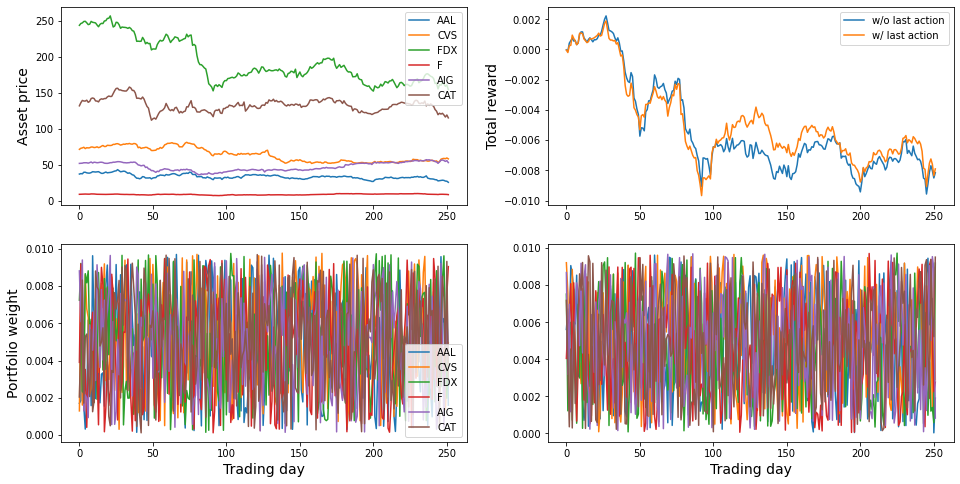

In [18]:
fig, axs = plt.subplots(2,2, figsize=(16,8))
    

axs[0,1].plot(reward_epi_wo_act, label='w/o last action')
axs[0,1].plot(reward_epi_w_act, label='w/ last action')

for i in range(len(asset_names)):
    axs[0,0].plot(price_epi[:,i+1], label=asset_names[i])
    
    axs[1,0].plot(action_epi_wo_act[:,i+1], label=asset_names[i])
    axs[1,1].plot(action_epi_w_act[:,i+1], label=asset_names[i])
    
axs[0,0].legend()
axs[1,0].legend()
axs[0,1].legend()
    
axs[1,0].set_xlabel('Trading day', fontsize=14)
axs[1,1].set_xlabel('Trading day', fontsize=14)
axs[0,0].set_ylabel('Asset price', fontsize=14)
axs[1,0].set_ylabel('Portfolio weight', fontsize=14)
axs[0,1].set_ylabel('Total reward', fontsize=14)
    

# With and without LSTM layer

## network params

In [19]:
network_params_wo_lstm = {
    'actor': {
        'fc': [256,128,64,32],
        'dropout': 0.5,
    },
    'critic': {
        'fc': [256,128,64,32],
        'dropout': 0.5,
    }
}

In [20]:
network_params_w_lstm = {
    'actor': {
        'lstm': {
            'hidden_dim': 20,
            'num_layers': 1
        },
        'fc': [256,128,64,32],
        'dropout': 0.5,
    },
    'critic': {
        'lstm': {
            'hidden_dim': 20,
            'num_layers': 1
        },
        'fc': [256,128,64,32],
        'dropout': 0.5,
    }
}

## setup

In [21]:
# with last action as state
agent_wo_lstm = RLAgent(state_dim,
                action_dim,
                k,
                network_params_wo_lstm,
                actor_learning_rate,
                critic_learning_rate
               )

agent_w_lstm = RLAgent(state_dim,
                action_dim,
                k,
                network_params_w_lstm,
                actor_learning_rate,
                critic_learning_rate
               )

[2021-03-07 23:32:08,733] <WARNING>:default_logger:The reduction property of criterion is not 'none', automatically corrected.
[2021-03-07 23:32:08,759] <WARNING>:default_logger:The reduction property of criterion is not 'none', automatically corrected.


In [22]:
env = TradingEnvironment(num_steps=trading_days, 
                         asset_names=asset_names, 
                         k=k, 
                         cost_bps=cost_bps,
                         agent_names=['wo_lstm','w_lstm'],
                         path_to_data=path_to_data
                        )

## training

In [23]:
env.reset()

reward_wo_lstm = []
elp_wo_lstm = []

reward_w_lstm = []
elp_w_lstm = []

reward_sm_wo_lstm = 0
reward_sm_w_lstm = 0
elp_sum = 0
start_time = time.time()

cols = ['r_wo_lstm','c_l_wo_lstm','a_v_wo_lstm',
        'r_w_lstm','c_l_w_lstm','a_v_w_lstm',
        'elp','elp_sum']
line = 'episode |' + '|'.join([f'{col:<12}' for col in cols])
print(line)


for e in range(max_episode):
    state, end = env.init_step()
    last_actions = env.simulator.last_actions
    
    while not end:
        with torch.no_grad():
            # generate action
            action_wo_lstm = agent_wo_lstm.get_action(torch.tensor(state[1], dtype=torch.float32).view(1,-1),
                                    torch.tensor(last_actions['wo_lstm'], dtype=torch.float32).view(1,-1))
            
            action_w_lstm = agent_w_lstm.get_action(torch.tensor(state[1], dtype=torch.float32).view(1,k,-1),
                                     torch.tensor(last_actions['w_lstm'], dtype=torch.float32).view(1,-1))
            
            # execute action and move to next step
            actions = {'wo_lstm': action_wo_lstm.numpy().reshape(-1),
                      'w_lstm': action_w_lstm.numpy().reshape(-1)}
            rewards, next_state, end = env.take_step(actions, state[0])
            
            # store experience
            agent_wo_lstm.store_transition({
                'state': {'state': torch.tensor(state[1], dtype=torch.float32).view(1,-1),
                         'last_action': torch.tensor(last_actions['wo_lstm'], dtype=torch.float32).view(1,-1)},
                'action': {'action': torch.tensor(actions['wo_lstm'], dtype=torch.float32).view(1,-1)},
                'next_state': {'state': torch.tensor(next_state[1], dtype=torch.float32).view(1,-1),
                              'last_action': torch.tensor(actions['wo_lstm'], dtype=torch.float32).view(1,-1)},
                'reward': rewards['wo_lstm'],
                'terminal': end
            })
            
            agent_w_lstm.store_transition({
                'state': {'state': torch.tensor(state[1], dtype=torch.float32).view(1,k,-1),
                         'last_action': torch.tensor(last_actions['w_lstm'], dtype=torch.float32).view(1,-1)},
                'action': {'action': torch.tensor(actions['w_lstm'], dtype=torch.float32).view(1,-1)},
                'next_state': {'state': torch.tensor(next_state[1], dtype=torch.float32).view(1,k,-1),
                              'last_action': torch.tensor(actions['w_lstm'], dtype=torch.float32).view(1,-1)},
                'reward': rewards['w_lstm'],
                'terminal': end
            })
        
        
        state = next_state
        last_actions = actions
        
    
    # update 
    start_time_wo_lstm = time.time()
    for _ in range(trading_days):
        actor_value_wo_lstm, critic_loss_wo_lstm = agent_wo_lstm.update(return_loss=True)
    elp_wo_lstm.append(time.time() - start_time_wo_lstm)
    
    start_time_w_lstm = time.time()
    for _ in range(trading_days):
        actor_value_w_lstm, critic_loss_w_lstm = agent_w_lstm.update(return_loss=True)
    elp_w_lstm.append(time.time() - start_time_w_lstm)
    
        
    rewards = env.get_total_rewards()
    reward_sm_wo_lstm = reward_sm_wo_lstm * 0.9 + rewards['wo_lstm'] * 0.1
    reward_corr_wo_lstm = reward_sm_wo_lstm/(1-0.9**(e+1))
    
    reward_sm_w_lstm = reward_sm_w_lstm * 0.9 + rewards['w_lstm'] * 0.1
    reward_corr_w_lstm = reward_sm_w_lstm/(1-0.9**(e+1))

    elp = time.time()-start_time
    elp_sum += elp
    start_time = time.time()
    
    reward_wo_lstm.append(reward_corr_wo_lstm)
    reward_w_lstm.append(reward_corr_w_lstm)
    
    
    
    
    line = f'{e:<8}|' + '|'.join([f'{col:<12.4f}' for col in [reward_corr_wo_lstm, critic_loss_wo_lstm, actor_value_wo_lstm,
                                                               reward_corr_w_lstm, critic_loss_w_lstm, actor_value_w_lstm,
                                                              elp, elp_sum]])
    
    print(line)
    
    env.reset()

[2021-03-07 23:33:27,855] <WARNING>:default_logger:You have not specified the i/o device of your model <class 'drl4dypm.agent.Actor'>, automatically determined and set to: cpu
The framework is not responsible for any un-matching device issues caused by this operation.
[2021-03-07 23:33:27,865] <WARNING>:default_logger:You have not specified the i/o device of your model <class 'drl4dypm.agent.Actor'>, automatically determined and set to: cpu
The framework is not responsible for any un-matching device issues caused by this operation.


episode |r_wo_lstm   |c_l_wo_lstm |a_v_wo_lstm |r_w_lstm    |c_l_w_lstm  |a_v_w_lstm  |elp         |elp_sum     


[2021-03-07 23:33:28,912] <WARNING>:default_logger:You have not specified the i/o device of your model <class 'drl4dypm.agent.Actor'>, automatically determined and set to: cpu
The framework is not responsible for any un-matching device issues caused by this operation.
[2021-03-07 23:33:28,915] <WARNING>:default_logger:You have not specified the i/o device of your model <class 'drl4dypm.agent.Critic'>, automatically determined and set to: cpu
The framework is not responsible for any un-matching device issues caused by this operation.
[2021-03-07 23:33:28,918] <WARNING>:default_logger:You have not specified the i/o device of your model <class 'drl4dypm.agent.Critic'>, automatically determined and set to: cpu
The framework is not responsible for any un-matching device issues caused by this operation.
[2021-03-07 23:33:33,930] <WARNING>:default_logger:You have not specified the i/o device of your model <class 'drl4dypm.agent.Actor'>, automatically determined and set to: cpu
The framework i

0       |0.0445      |0.0001      |-0.0423     |0.0435      |0.0001      |0.0941      |21.3961     |21.3961     
1       |-0.0641     |0.0001      |-0.0410     |0.0158      |0.0001      |0.0915      |21.8256     |43.2217     
2       |-0.0693     |0.0001      |-0.0407     |-0.0194     |0.0001      |0.0906      |21.1423     |64.3640     
3       |0.0163      |0.0001      |-0.0378     |0.0804      |0.0001      |0.0981      |20.9641     |85.3281     
4       |-0.0075     |0.0001      |-0.0345     |0.1827      |0.0002      |0.1033      |21.5080     |106.8360    
5       |-0.0004     |0.0001      |-0.0343     |0.2148      |0.0002      |0.1047      |20.9901     |127.8262    
6       |-0.0109     |0.0001      |-0.0335     |0.2711      |0.0002      |0.1104      |20.8464     |148.6726    
7       |0.0177      |0.0001      |-0.0309     |0.2754      |0.0002      |0.1044      |20.9257     |169.5983    
8       |0.0443      |0.0001      |-0.0318     |0.2451      |0.0003      |0.1041      |20.9678  

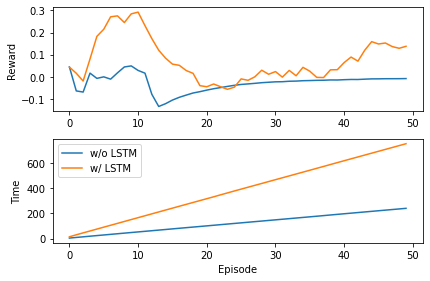

In [25]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(6,4))

ax1.plot(reward_wo_lstm)
ax1.plot(reward_w_lstm)


ax2.plot(np.array(elp_wo_lstm).cumsum(), label='w/o LSTM')
ax2.plot(np.array(elp_w_lstm).cumsum(), label='w/ LSTM')
ax2.legend()

ax1.set_ylabel('Reward')
ax2.set_ylabel('Time')
ax2.set_xlabel('Episode')

fig.tight_layout()
fig.savefig('figs/cmp_lstm_w_last_act.png')

## test

In [32]:
env.reset()

price_epi = []
action_epi_wo_lstm = []
action_epi_w_lstm = []
reward_epi_wo_lstm = []
reward_epi_w_lstm = []



state, end = env.init_step()
last_actions = env.simulator.last_actions
    
while not end:
    with torch.no_grad():
        # generate action
        action_wo_lstm = agent_wo_lstm.get_action(torch.tensor(state[1], dtype=torch.float32).view(1,-1),
                                torch.tensor(last_actions['w_lstm'], dtype=torch.float32).view(1,-1))

        action_w_lstm = agent_w_lstm.get_action(torch.tensor(state[1], dtype=torch.float32).view(1,k,-1),
                                 torch.tensor(last_actions['w_lstm'], dtype=torch.float32).view(1,-1))

        # execute action and move to next step
        actions = {'wo_lstm': action_wo_lstm.numpy().reshape(-1),
                  'w_lstm': action_w_lstm.numpy().reshape(-1)}
        rewards, next_state, end = env.take_step(actions, state[0])


    state = next_state
    last_actions = actions
    
    price_epi.append(state[0])
    action_epi_wo_lstm.append(action_wo_lstm.numpy().reshape(-1))
    action_epi_w_lstm.append(action_w_lstm.numpy().reshape(-1))
    reward_epi_wo_lstm.append(rewards['wo_lstm'])
    reward_epi_w_lstm.append(rewards['w_lstm'])

    

In [33]:
reward_epi_wo_lstm = np.array(reward_epi_wo_lstm).cumsum()
reward_epi_w_lstm = np.array(reward_epi_w_lstm).cumsum()

price_epi = np.array(price_epi)
action_epi_wo_lstm = np.array(action_epi_wo_lstm)
action_epi_w_lstm = np.array(action_epi_w_lstm)


Text(0, 0.5, 'Total reward')

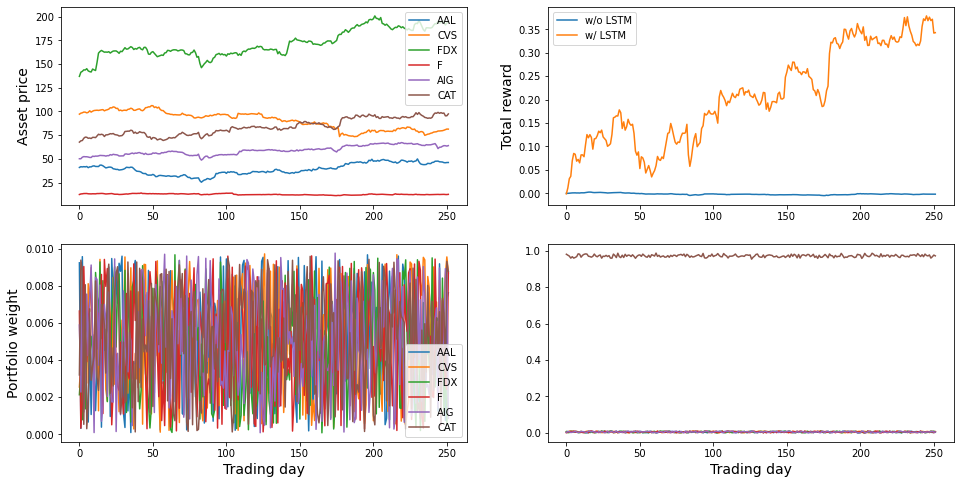

In [31]:
fig, axs = plt.subplots(2,2, figsize=(16,8))
    

axs[0,1].plot(reward_epi_wo_lstm, label='w/o LSTM')
axs[0,1].plot(reward_epi_w_lstm, label='w/ LSTM')

for i in range(len(asset_names)):
    axs[0,0].plot(price_epi[:,i+1], label=asset_names[i])
    
    axs[1,0].plot(action_epi_wo_lstm[:,i+1], label=asset_names[i])
    axs[1,1].plot(action_epi_w_lstm[:,i+1], label=asset_names[i])
    
axs[0,0].legend()
axs[1,0].legend()
axs[0,1].legend()
    
axs[1,0].set_xlabel('Trading day', fontsize=14)
axs[1,1].set_xlabel('Trading day', fontsize=14)
axs[0,0].set_ylabel('Asset price', fontsize=14)
axs[1,0].set_ylabel('Portfolio weight', fontsize=14)
axs[0,1].set_ylabel('Total reward', fontsize=14)
    

# IPM

In [41]:
def RMSE(y,y_hat):
    y = np.array(y)
    y_hat = np.array(y_hat)
    return np.sqrt(np.sum(np.mean(np.square(y-y_hat), axis=0)))

## network params

In [42]:
network_params = {
    'actor': {
        'lstm': {
            'hidden_dim': 20,
            'num_layers': 1
        },
        'fc': [256,128,64,32],
        'dropout': 0.5
    },
    'critic': {
        'lstm': {
            'hidden_dim': 20,
            'num_layers': 1
        },
        'fc': [256,128,64,32],
        'dropout': 0.5
    }
}


# IPM params
ipm_params = {
    'input_dim': 3*num_assets,
    'learning_rate': 0.1**3,
    'rnn_dim': 20,
    'delay': 3,
    'decay_rates': [0.1,0.2,0.5,0.8],
    'spectral_radius': 0.95,
    'sparsity': 0.5,
    'noise_mean': 0.,
    'noise_std': 0.01,
    'filter_window_length': 5,
    'filter_polyorder': 3
}


## setup

In [67]:
agent_base = RLAgent(state_dim,
                action_dim,
                k,
                network_params,
                actor_learning_rate,
                critic_learning_rate
               )

agent_ipm = RLAgent(state_dim,
                action_dim,
                k,
                network_params,
                actor_learning_rate,
                critic_learning_rate,
                ipm_params=ipm_params
               )

[2021-03-08 01:23:30,665] <WARNING>:default_logger:The reduction property of criterion is not 'none', automatically corrected.
[2021-03-08 01:23:31,020] <WARNING>:default_logger:The reduction property of criterion is not 'none', automatically corrected.


In [68]:
env = TradingEnvironment(num_steps=trading_days, 
                         asset_names=asset_names, 
                         k=k, 
                         cost_bps=cost_bps,
                         agent_names=['base','ipm'],
                         path_to_data=path_to_data
                        )

## training

In [69]:
env.reset()

reward_base = []
reward_ipm = []
err_ipm = []

reward_sm_base = 0
reward_sm_ipm = 0
elp_sum = 0
start_time = time.time()

cols = ['r_base','c_l_base','a_v_base',
        'r_ipm','c_l_ipm','a_v_ipm', 'err_ipm',
        'elp','elp_sum']
line = 'episode |' + '|'.join([f'{col:<10}' for col in cols])
print(line)



for e in range(max_episode):
    state, end = env.init_step()
    last_actions = env.simulator.last_actions
    
    y = []
    yhat = []
    
    # get IPM prediction
    ipm_predict = agent_ipm.ipm_predict_and_learn(state[-1])
    yhat.append(ipm_predict)
    
    while not end:
        with torch.no_grad():
            # generate action
            action_base = agent_base.get_action(torch.tensor(state[1], dtype=torch.float32).view(1,k,-1),
                                        last_action=torch.tensor(last_actions['base'], dtype=torch.float32).view(1,-1))
            action_ipm = agent_ipm.get_action(torch.tensor(state[1], dtype=torch.float32).view(1,k,-1),
                                        last_action=torch.tensor(last_actions['ipm'], dtype=torch.float32).view(1,-1),
                                        ipm_predict=torch.tensor(ipm_predict, dtype=torch.float32).view(1,-1))
            
            # execute action and move to next step
            actions = {'base': action_base.numpy().reshape(-1),
                      'ipm': action_ipm.numpy().reshape(-1)}
            rewards, next_state, end = env.take_step(actions, state[0])
            
            # train IPM with next state and get next prediction
            next_ipm_predict = agent_ipm.ipm_predict_and_learn(state[-1], next_state[-1])
            
            y.append(next_state[-1])
            yhat.append(next_ipm_predict)
            
            
            # store experience
            agent_base.store_transition({
                'state': {'state': torch.tensor(state[1], dtype=torch.float32).view(1,k,-1),
                         'last_action': torch.tensor(last_actions['base'], dtype=torch.float32).view(1,-1)},
                'action': {'action': torch.tensor(actions['base'], dtype=torch.float32).view(1,-1)},
                'next_state': {'state': torch.tensor(next_state[1], dtype=torch.float32).view(1,k,-1),
                        'last_action': torch.tensor(actions['base'], dtype=torch.float32).view(1,-1)},
                'reward': rewards['base'],
                'terminal': end
            })
            
            agent_ipm.store_transition({
                'state': {'state': torch.tensor(state[1], dtype=torch.float32).view(1,k,-1),
                          'last_action': torch.tensor(last_actions['ipm'], dtype=torch.float32).view(1,-1),
                         'ipm': torch.tensor(ipm_predict, dtype=torch.float32).view(1,-1)},
                'action': {'action': torch.tensor(actions['ipm'], dtype=torch.float32).view(1,-1)},
                'next_state': {'state': torch.tensor(next_state[1], dtype=torch.float32).view(1,k,-1),
                               'last_action': torch.tensor(actions['ipm'], dtype=torch.float32).view(1,-1),
                              'ipm': torch.tensor(next_ipm_predict, dtype=torch.float32).view(1,-1)},
                'reward': rewards['ipm'],
                'terminal': end
            })
            
        state = next_state
        last_actions = actions
        ipm_predict = next_ipm_predict
        
        
        
    for _ in range(trading_days):
        actor_value_base, critic_loss_base = agent_base.update(return_loss=True)
        actor_value_ipm, critic_loss_ipm = agent_ipm.update(return_loss=True)
    
    
    rewards = env.get_total_rewards()
    reward_sm_base = reward_sm_base * 0.9 + rewards['base'] * 0.1
    reward_corr_base = reward_sm_base/(1-0.9**(e+1))
    
    reward_sm_ipm = reward_sm_ipm * 0.9 + rewards['ipm'] * 0.1
    reward_corr_ipm = reward_sm_ipm/(1-0.9**(e+1))
    
    
    err_ipm.append(RMSE(y, yhat[:-1]))
    reward_base.append(reward_corr_base)
    reward_ipm.append(reward_corr_ipm)
    
    elp = time.time()-start_time
    elp_sum += elp
    start_time = time.time()
    
    line = f'{e:<8}|' + '|'.join([f'{col:<10.4f}' for col in [reward_corr_base, critic_loss_base, actor_value_base,
                                                               reward_corr_ipm, critic_loss_ipm, actor_value_ipm, 
                                                              err_ipm[-1], elp, elp_sum]])
    
    print(line)
    
    env.reset()
    agent_ipm.ipm_init()

[2021-03-08 01:23:35,360] <WARNING>:default_logger:You have not specified the i/o device of your model <class 'drl4dypm.agent.Actor'>, automatically determined and set to: cpu
The framework is not responsible for any un-matching device issues caused by this operation.
[2021-03-08 01:23:35,363] <WARNING>:default_logger:You have not specified the i/o device of your model <class 'drl4dypm.agent.Actor'>, automatically determined and set to: cpu
The framework is not responsible for any un-matching device issues caused by this operation.


episode |r_base    |c_l_base  |a_v_base  |r_ipm     |c_l_ipm   |a_v_ipm   |err_ipm   |elp       |elp_sum   


[2021-03-08 01:23:36,809] <WARNING>:default_logger:You have not specified the i/o device of your model <class 'drl4dypm.agent.Actor'>, automatically determined and set to: cpu
The framework is not responsible for any un-matching device issues caused by this operation.
[2021-03-08 01:23:36,817] <WARNING>:default_logger:You have not specified the i/o device of your model <class 'drl4dypm.agent.Critic'>, automatically determined and set to: cpu
The framework is not responsible for any un-matching device issues caused by this operation.
[2021-03-08 01:23:36,828] <WARNING>:default_logger:You have not specified the i/o device of your model <class 'drl4dypm.agent.Critic'>, automatically determined and set to: cpu
The framework is not responsible for any un-matching device issues caused by this operation.
[2021-03-08 01:23:36,905] <WARNING>:default_logger:You have not specified the i/o device of your model <class 'drl4dypm.agent.Actor'>, automatically determined and set to: cpu
The framework i

0       |-0.2124   |0.0001    |0.0372    |-0.2057   |0.0001    |0.1450    |0.0875    |32.5854   |32.5854   
1       |-0.0711   |0.0001    |0.0098    |-0.1738   |0.0002    |0.1427    |0.0736    |32.3231   |64.9085   
2       |-0.0934   |0.0002    |0.0011    |-0.1453   |0.0002    |0.1346    |0.0670    |32.3752   |97.2837   
3       |-0.0592   |0.0001    |-0.0058   |-0.0418   |0.0001    |0.1274    |0.0738    |32.5422   |129.8259  
4       |-0.0299   |0.0001    |-0.0043   |-0.0084   |0.0001    |0.1242    |0.0656    |32.4386   |162.2645  
5       |-0.0387   |0.0001    |-0.0080   |-0.0000   |0.0002    |0.1331    |0.0735    |32.3786   |194.6432  
6       |-0.0488   |0.0002    |-0.0131   |-0.0827   |0.0002    |0.1328    |0.0894    |32.7508   |227.3940  
7       |-0.0294   |0.0002    |-0.0119   |-0.1495   |0.0002    |0.1292    |0.1599    |32.1856   |259.5796  
8       |-0.0264   |0.0002    |-0.0066   |-0.1358   |0.0003    |0.1333    |0.0880    |32.2230   |291.8026  
9       |-0.0223   |0.0002  

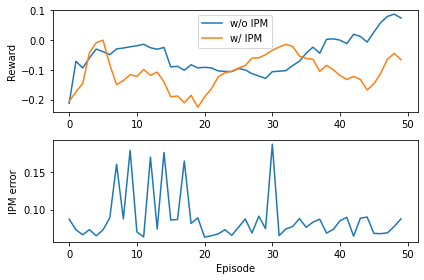

In [71]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(6,4))

ax1.plot(reward_base, label='w/o IPM')
ax1.plot(reward_ipm, label='w/ IPM')
ax1.legend()

ax2.plot(err_ipm)

ax1.set_ylabel('Reward')
ax2.set_ylabel('IPM error')
ax2.set_xlabel('Episode')


fig.tight_layout()
fig.savefig('figs/cmp_ipm.png')

## test

In [75]:
env.reset()

price_epi = []
action_epi_base = []
action_epi_ipm = []
reward_epi_base = []
reward_epi_ipm = []



state, end = env.init_step()
last_actions = env.simulator.last_actions
ipm_predict = agent_ipm.ipm_predict_and_learn(state[-1])
    
while not end:
    with torch.no_grad():
        # generate action
        action_base = agent_base.get_action(torch.tensor(state[1], dtype=torch.float32).view(1,k,-1),
                                torch.tensor(last_actions['base'], dtype=torch.float32).view(1,-1))

        action_ipm = agent_ipm.get_action(torch.tensor(state[1], dtype=torch.float32).view(1,k,-1),
                                torch.tensor(last_actions['ipm'], dtype=torch.float32).view(1,-1),
                                torch.tensor(ipm_predict, dtype=torch.float32).view(1,-1))

        # execute action and move to next step
        actions = {'base': action_base.numpy().reshape(-1),
                  'ipm': action_ipm.numpy().reshape(-1)}
        rewards, next_state, end = env.take_step(actions, state[0])
        
        # train IPM with next state and get next prediction
        next_ipm_predict = agent_ipm.ipm_predict_and_learn(state[-1], next_state[-1])


    state = next_state
    last_actions = actions
    ipm_predict = next_ipm_predict
    
    
    price_epi.append(state[0])
    action_epi_base.append(action_base.numpy().reshape(-1))
    action_epi_ipm.append(action_ipm.numpy().reshape(-1))
    reward_epi_base.append(rewards['base'])
    reward_epi_ipm.append(rewards['ipm'])

    

In [76]:
reward_epi_base = np.array(reward_epi_base).cumsum()
reward_epi_ipm = np.array(reward_epi_ipm).cumsum()

price_epi = np.array(price_epi)
action_epi_base = np.array(action_epi_base)
action_epi_ipm = np.array(action_epi_ipm)


Text(0, 0.5, 'Total reward')

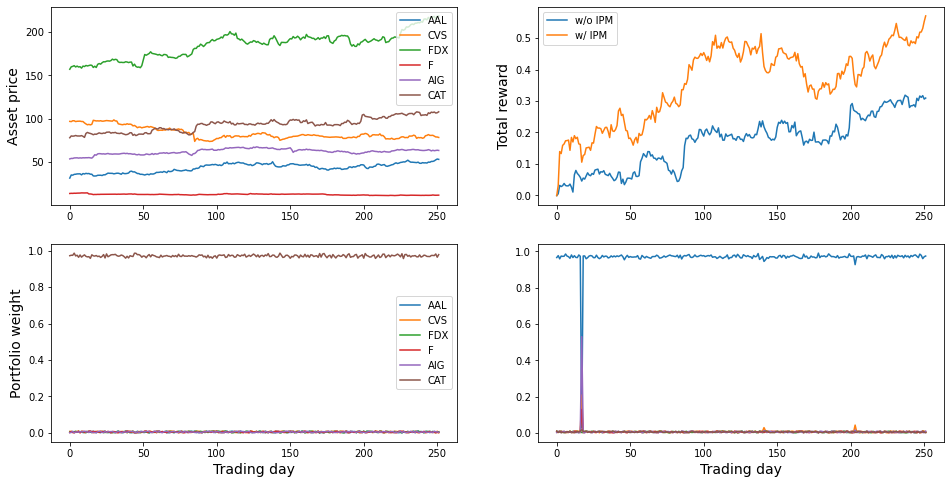

In [74]:
fig, axs = plt.subplots(2,2, figsize=(16,8))
    

axs[0,1].plot(reward_epi_base, label='w/o IPM')
axs[0,1].plot(reward_epi_ipm, label='w/ IPM')

for i in range(len(asset_names)):
    axs[0,0].plot(price_epi[:,i+1], label=asset_names[i])
    
    axs[1,0].plot(action_epi_base[:,i+1], label=asset_names[i])
    axs[1,1].plot(action_epi_ipm[:,i+1], label=asset_names[i])
    
axs[0,0].legend()
axs[1,0].legend()
axs[0,1].legend()
    
axs[1,0].set_xlabel('Trading day', fontsize=14)
axs[1,1].set_xlabel('Trading day', fontsize=14)
axs[0,0].set_ylabel('Asset price', fontsize=14)
axs[1,0].set_ylabel('Portfolio weight', fontsize=14)
axs[0,1].set_ylabel('Total reward', fontsize=14)
    

# BCM

## network params

In [53]:
network_params = {
    'actor': {
        'lstm': {
            'hidden_dim': 20,
            'num_layers': 1
        },
        'fc': [256,128,64,32],
        'dropout': 0.5
    },
    'critic': {
        'lstm': {
            'hidden_dim': 20,
            'num_layers': 1
        },
        'fc': [256,128,64,32],
        'dropout': 0.5
    }
}

# BCM params
bcm_params = {
    'cost_bps': cost_bps,
    'update_rate': 0.1
}

## setup

In [54]:
agent_base = RLAgent(state_dim,
                action_dim,
                k,
                network_params,
                actor_learning_rate,
                critic_learning_rate
               )

agent_bcm = RLAgent(state_dim,
                action_dim,
                k,
                network_params,
                actor_learning_rate,
                critic_learning_rate,
                bcm_params=bcm_params
               )

[2021-03-08 00:40:05,118] <WARNING>:default_logger:The reduction property of criterion is not 'none', automatically corrected.
[2021-03-08 00:40:05,395] <WARNING>:default_logger:The reduction property of criterion is not 'none', automatically corrected.


In [55]:
env = TradingEnvironment(num_steps=trading_days, 
                         asset_names=asset_names, 
                         k=k, 
                         cost_bps=cost_bps,
                         agent_names=['base','bcm'],
                         path_to_data=path_to_data
                        )

## training

In [56]:
env.reset()

reward_base = []
reward_bcm = []
diff_act = []

reward_sm_base = 0
reward_sm_bcm = 0
elp_sum = 0
start_time = time.time()

cols = ['r_base','c_l_base','a_v_base',
        'r_bcm','c_l_bcm','a_v_bcm_p1', 'a_v_bcm_p2', 'diff_act',
        'elp','elp_sum']
line = 'episode |' + '|'.join([f'{col:<10}' for col in cols])
print(line)



for e in range(max_episode):
    state, end = env.init_step()
    last_actions = env.simulator.last_actions
    diff_act_step = []
    
    while not end:
        with torch.no_grad():
            # generate action
            action_base = agent_base.get_action(torch.tensor(state[1], dtype=torch.float32).view(1,k,-1),
                                            last_action=torch.tensor(last_actions['base'], dtype=torch.float32).view(1,-1))
            action_bcm = agent_bcm.get_action(torch.tensor(state[1], dtype=torch.float32).view(1,k,-1),
                                            last_action=torch.tensor(last_actions['bcm'], dtype=torch.float32).view(1,-1))
            
            # execute action and move to next step
            actions = {'base': action_base.numpy().reshape(-1),
                      'bcm': action_bcm.numpy().reshape(-1)}
            rewards, next_state, end = env.take_step(actions, state[0])
            
            
            # get CBM action
            bcm_action_bcm = agent_bcm.get_bcm_action(state[0], next_state[0])
            diff_act_step.append(np.linalg.norm(bcm_action_bcm-action_bcm.numpy().reshape(-1), ord=1))
            
            
            # store experience
            agent_base.store_transition({
                'state': {'state': torch.tensor(state[1], dtype=torch.float32).view(1,k,-1),
                         'last_action': torch.tensor(last_actions['base'], dtype=torch.float32).view(1,-1)},
                'action': {'action': torch.tensor(actions['base'], dtype=torch.float32).view(1,-1)},
                'next_state': {'state': torch.tensor(next_state[1], dtype=torch.float32).view(1,k,-1),
                          'last_action': torch.tensor(actions['base'], dtype=torch.float32).view(1,-1)},
                'reward': rewards['base'],
                'terminal': end
            })
            
            agent_bcm.store_transition({
                'state': {'state': torch.tensor(state[1], dtype=torch.float32).view(1,k,-1),
                         'last_action': torch.tensor(last_actions['bcm'], dtype=torch.float32).view(1,-1)},
                'action': {'action': torch.tensor(actions['bcm'], dtype=torch.float32).view(1,-1)},
                'next_state': {'state': torch.tensor(next_state[1], dtype=torch.float32).view(1,k,-1),
                         'last_action': torch.tensor(actions['bcm'], dtype=torch.float32).view(1,-1)},
                'reward': rewards['bcm'],
                'terminal': end,
                'bcm_action': torch.tensor(bcm_action_bcm)
            })
            
        state = next_state
        last_actions = actions
        
        
        
    for _ in range(trading_days):
        actor_value_base, critic_loss_base = agent_base.update(return_loss=True)
        (actor_value_bcm_p1, actor_value_bcm_p2), critic_loss_bcm = agent_bcm.update(return_loss=True)
    
    
    rewards = env.get_total_rewards()
    reward_sm_base = reward_sm_base * 0.9 + rewards['base'] * 0.1
    reward_corr_base = reward_sm_base/(1-0.9**(e+1))
    
    reward_sm_bcm = reward_sm_bcm * 0.9 + rewards['bcm'] * 0.1
    reward_corr_bcm = reward_sm_bcm/(1-0.9**(e+1))
    
    
    diff_act.append(np.mean(diff_act_step))
    reward_base.append(reward_corr_base)
    reward_bcm.append(reward_corr_bcm)
    
    elp = time.time()-start_time
    elp_sum += elp
    start_time = time.time()
    
    line = f'{e:<8}|' + '|'.join([f'{col:<10.4f}' for col in [reward_corr_base, critic_loss_base, actor_value_base,
                                                               reward_corr_bcm, critic_loss_bcm, 
                                                               actor_value_bcm_p1, actor_value_bcm_p2,
                                                               diff_act[-1], elp, elp_sum]])
    
    print(line)
    
    env.reset()

[2021-03-08 00:44:16,640] <WARNING>:default_logger:You have not specified the i/o device of your model <class 'drl4dypm.agent.Actor'>, automatically determined and set to: cpu
The framework is not responsible for any un-matching device issues caused by this operation.
[2021-03-08 00:44:16,657] <WARNING>:default_logger:You have not specified the i/o device of your model <class 'drl4dypm.agent.Actor'>, automatically determined and set to: cpu
The framework is not responsible for any un-matching device issues caused by this operation.


episode |r_base    |c_l_base  |a_v_base  |r_bcm     |c_l_bcm   |a_v_bcm_p1|a_v_bcm_p2|diff_act  |elp       |elp_sum   


[2021-03-08 00:44:25,649] <WARNING>:default_logger:You have not specified the i/o device of your model <class 'drl4dypm.agent.Actor'>, automatically determined and set to: cpu
The framework is not responsible for any un-matching device issues caused by this operation.
[2021-03-08 00:44:25,659] <WARNING>:default_logger:You have not specified the i/o device of your model <class 'drl4dypm.agent.Critic'>, automatically determined and set to: cpu
The framework is not responsible for any un-matching device issues caused by this operation.
[2021-03-08 00:44:25,668] <WARNING>:default_logger:You have not specified the i/o device of your model <class 'drl4dypm.agent.Critic'>, automatically determined and set to: cpu
The framework is not responsible for any un-matching device issues caused by this operation.
[2021-03-08 00:44:25,757] <WARNING>:default_logger:You have not specified the i/o device of your model <class 'drl4dypm.agent.Actor'>, automatically determined and set to: cpu
The framework i

0       |-0.2721   |0.0002    |0.1316    |-0.2690   |0.0001    |-0.0732   |-0.4046   |1.6996    |39.3659   |39.3659   
1       |-0.2913   |0.0003    |0.1271    |-0.2103   |0.0001    |-0.0779   |-0.3996   |1.6908    |38.5478   |77.9137   
2       |-0.2809   |0.0002    |0.1358    |-0.1512   |0.0002    |-0.0720   |-0.4033   |1.6821    |39.3447   |117.2583  
3       |-0.2071   |0.0004    |0.1442    |-0.1239   |0.0002    |-0.0620   |-0.3922   |1.6825    |39.4796   |156.7379  
4       |-0.2379   |0.0003    |0.1418    |-0.1182   |0.0002    |-0.0589   |-0.4010   |1.6747    |39.4547   |196.1926  
5       |-0.2509   |0.0003    |0.1306    |-0.1314   |0.0002    |-0.0573   |-0.4005   |1.6691    |38.7947   |234.9873  
6       |-0.1323   |0.0005    |0.1387    |-0.0791   |0.0003    |-0.0667   |-0.3960   |1.6730    |39.8060   |274.7934  
7       |-0.2153   |0.0004    |0.1457    |-0.0354   |0.0003    |-0.0531   |-0.3926   |1.6571    |38.8376   |313.6310  
8       |-0.2371   |0.0004    |0.1371    |-0.049

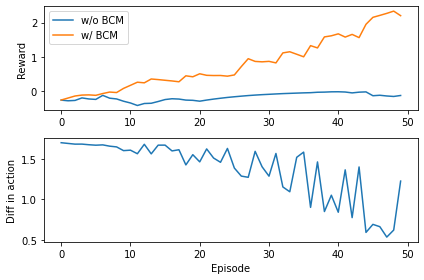

In [58]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(6,4))

ax1.plot(reward_base, label='w/o BCM')
ax1.plot(reward_bcm, label='w/ BCM ')


ax2.plot(diff_act)

ax1.set_ylabel('Reward')
ax2.set_ylabel('Diff in action')
ax2.set_xlabel('Episode')
ax1.legend()

fig.tight_layout()
fig.savefig('figs/cmp_bcm.png')

## test

In [60]:
env.reset()

price_epi = []
action_epi_base = []
action_epi_bcm = []
reward_epi_base = []
reward_epi_bcm = []



state, end = env.init_step()
last_actions = env.simulator.last_actions
    
while not end:
    with torch.no_grad():
        # generate action
        action_base = agent_base.get_action(torch.tensor(state[1], dtype=torch.float32).view(1,k,-1),
                                torch.tensor(last_actions['base'], dtype=torch.float32).view(1,-1))

        action_bcm = agent_bcm.get_action(torch.tensor(state[1], dtype=torch.float32).view(1,k,-1),
                                torch.tensor(last_actions['bcm'], dtype=torch.float32).view(1,-1))

        # execute action and move to next step
        actions = {'base': action_base.numpy().reshape(-1),
                  'bcm': action_bcm.numpy().reshape(-1)}
        rewards, next_state, end = env.take_step(actions, state[0])
        

    state = next_state
    last_actions = actions
    
    
    price_epi.append(state[0])
    action_epi_base.append(action_base.numpy().reshape(-1))
    action_epi_bcm.append(action_bcm.numpy().reshape(-1))
    reward_epi_base.append(rewards['base'])
    reward_epi_bcm.append(rewards['bcm'])

    

In [61]:
reward_epi_base = np.array(reward_epi_base).cumsum()
reward_epi_bcm = np.array(reward_epi_bcm).cumsum()

price_epi = np.array(price_epi)
action_epi_base = np.array(action_epi_base)
action_epi_bcm = np.array(action_epi_bcm)


Text(0, 0.5, 'Total reward')

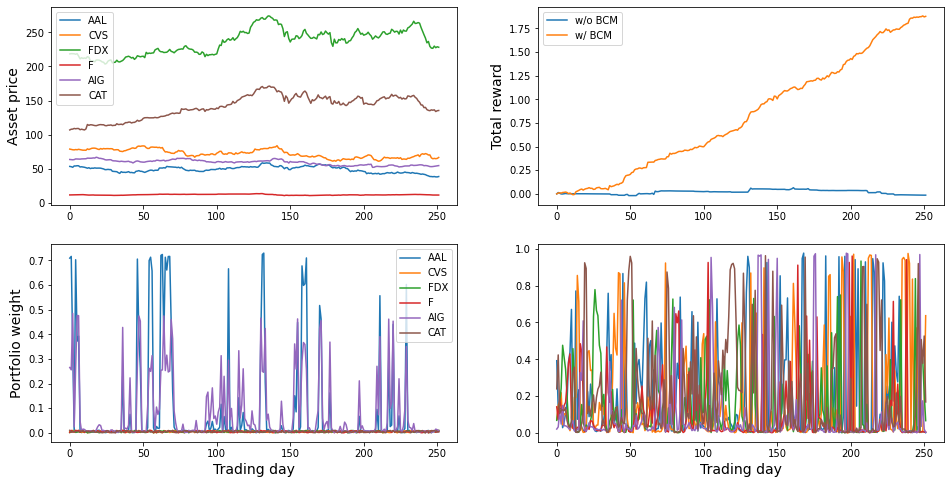

In [62]:
fig, axs = plt.subplots(2,2, figsize=(16,8))
    

axs[0,1].plot(reward_epi_base, label='w/o BCM')
axs[0,1].plot(reward_epi_bcm, label='w/ BCM')

for i in range(len(asset_names)):
    axs[0,0].plot(price_epi[:,i+1], label=asset_names[i])
    
    axs[1,0].plot(action_epi_base[:,i+1], label=asset_names[i])
    axs[1,1].plot(action_epi_bcm[:,i+1], label=asset_names[i])
    
axs[0,0].legend()
axs[1,0].legend()
axs[0,1].legend()
    
axs[1,0].set_xlabel('Trading day', fontsize=14)
axs[1,1].set_xlabel('Trading day', fontsize=14)
axs[0,0].set_ylabel('Asset price', fontsize=14)
axs[1,0].set_ylabel('Portfolio weight', fontsize=14)
axs[0,1].set_ylabel('Total reward', fontsize=14)
    